In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
from mlxtend.classifier import StackingCVClassifier
from sklearn import preprocessing
import seaborn as sns 
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn import ensemble,model_selection,svm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
train = pd.read_csv('E:/files/Kaggle/Forest Cover Type/train.csv')
test = pd.read_csv('E:/files/Kaggle/Forest Cover Type/test.csv')
y=train['Cover_Type']

In [5]:
train = train.values
test = test.values
y = y.values

In [11]:
import xgboost as xgb

kf = KFold(n_splits=5, random_state=3228, shuffle=True)
for train_index, test_index in kf.split(train):
    print(train_index)
    print(test_index)
    X_ktrain, X_ktest = train[train_index], train[test_index]
    y_ktrain, y_ktest = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_ktrain, label=y_ktrain)
dvalid = xgb.DMatrix(X_ktest, label=y_ktest)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

[    1     3     4 ... 15116 15117 15119]
[    0     2     8 ... 15102 15114 15118]
[    0     1     2 ... 15115 15116 15118]
[    3    10    12 ... 15110 15117 15119]
[    0     1     2 ... 15117 15118 15119]
[   15    17    20 ... 15097 15099 15100]
[    0     1     2 ... 15117 15118 15119]
[    4     9    19 ... 15112 15115 15116]
[    0     2     3 ... 15117 15118 15119]
[    1     5     6 ... 15094 15104 15113]


In [10]:
X_ktrain.shape

(12096, 56)

In [34]:
# One-cool binary columns (reverse of one-hot encoding procedure)

train['soil_type'] = 0
for i in range(1, 41):
    train['soil_type'] += i * train['Soil_Type' + str(i)]
train['warea'] = 0
for i in range(1, 5):
    train['warea'] += i * train['Wilderness_Area' + str(i)]
    
test['soil_type'] = 0
for i in range(1, 41):
    test['soil_type'] += i * test['Soil_Type' + str(i)]
test['warea'] = 0
for i in range(1, 5):
    test['warea'] += i * test['Wilderness_Area' + str(i)]

In [35]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,soil_type,warea
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,5,29,1
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,5,29,1
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,2,12,1
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,2,30,1
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,5,29,1


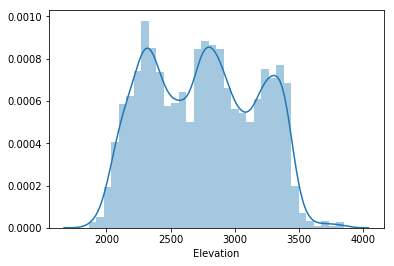

In [36]:
sns.distplot(train['Elevation'])

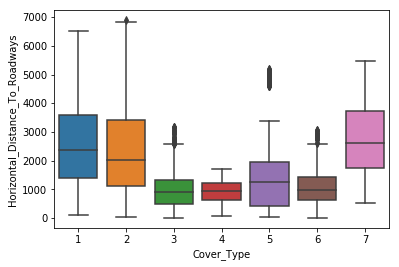

In [37]:
sns.boxplot(x='Cover_Type', y='Horizontal_Distance_To_Roadways', data=train)

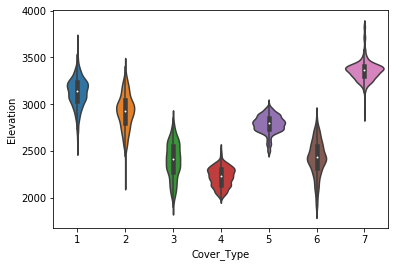

In [38]:
sns.violinplot(x = 'Cover_Type', y = 'Elevation', data = train)# , hue = 'Survived'

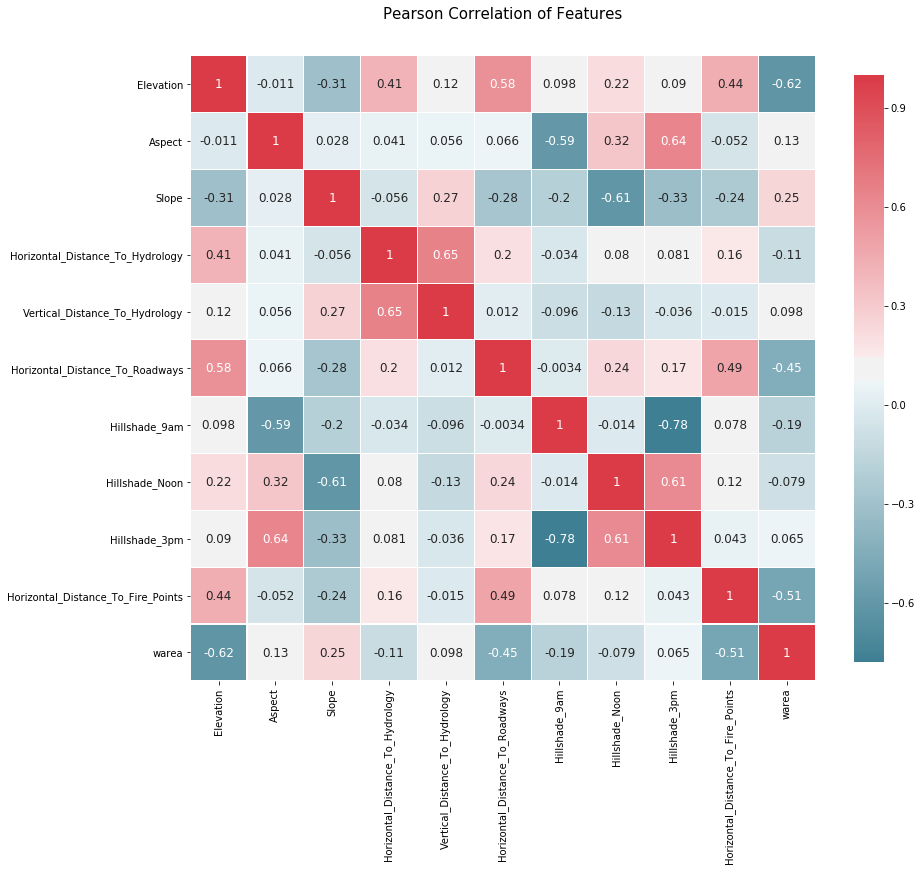

In [39]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(pd.concat([train.iloc[:,1:11],train.iloc[:,-1]],axis=1))

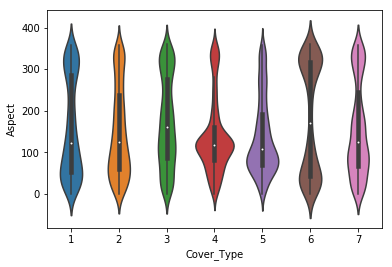

In [40]:
sns.violinplot(x = 'Cover_Type', y = 'Aspect', data = train)

In [41]:
train['Soil_Type12_32'] = train['Soil_Type32'] + train['Soil_Type12']
test['Soil_Type12_32'] = test['Soil_Type32'] + test['Soil_Type12']
train['Soil_Type23_22_32_33'] = train['Soil_Type23'] + train['Soil_Type22'] + train['Soil_Type32'] + train['Soil_Type33']
test['Soil_Type23_22_32_33'] = test['Soil_Type23'] + test['Soil_Type22'] + test['Soil_Type32'] + test['Soil_Type33']

In [42]:
train.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

In [43]:
# checking the value count for different soil_type
for i in range(15,55):
    print(train[train.columns[i]].value_counts())

0    14765
1      355
Name: Soil_Type1, dtype: int64
0    14497
1      623
Name: Soil_Type2, dtype: int64
0    14158
1      962
Name: Soil_Type3, dtype: int64
0    14277
1      843
Name: Soil_Type4, dtype: int64
0    14955
1      165
Name: Soil_Type5, dtype: int64
0    14470
1      650
Name: Soil_Type6, dtype: int64
0    15120
Name: Soil_Type7, dtype: int64
0    15119
1        1
Name: Soil_Type8, dtype: int64
0    15110
1       10
Name: Soil_Type9, dtype: int64
0    12978
1     2142
Name: Soil_Type10, dtype: int64
0    14714
1      406
Name: Soil_Type11, dtype: int64
0    14893
1      227
Name: Soil_Type12, dtype: int64
0    14644
1      476
Name: Soil_Type13, dtype: int64
0    14951
1      169
Name: Soil_Type14, dtype: int64
0    15120
Name: Soil_Type15, dtype: int64
0    15006
1      114
Name: Soil_Type16, dtype: int64
0    14508
1      612
Name: Soil_Type17, dtype: int64
0    15060
1       60
Name: Soil_Type18, dtype: int64
0    15074
1       46
Name: Soil_Type19, dtype: int64
0    

In [44]:
df=train.copy()
df['Id']=df['Id']+15120
df['Horizontal_Distance_To_Hydrology']=df['Horizontal_Distance_To_Hydrology']+np.random.randint(-10,10)
df['Horizontal_Distance_To_Fire_Points']=df['Horizontal_Distance_To_Fire_Points']+np.random.randint(-10,10)
df['Elevation']=df['Elevation']+np.random.randint(-50,50)
df['Horizontal_Distance_To_Roadways']=df['Horizontal_Distance_To_Roadways']+np.random.randint(-10,10)

train=train.append(df,ignore_index=True)
train.shape

(30240, 60)

In [45]:
# train['Hillshade_mean']=(train['Hillshade_9am']+train['Hillshade_Noon']+train['Hillshade_3pm'])/3
# test['Hillshade_mean']=(test['Hillshade_9am']+test['Hillshade_Noon']+test['Hillshade_3pm'])/3

# train['Elevation']=np.log1p(train['Elevation'])
# test['Elevation']=np.log1p(test['Elevation'])

In [46]:
# ####################### Train data #############################################
# train['HF1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
# train['HF2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
# train['HR1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
# train['HR2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
# train['FR1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
# train['FR2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
# train['ele_vert'] = train.Elevation-train.Vertical_Distance_To_Hydrology

# train['slope_hyd'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
# train.slope_hyd=train.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

# #Mean distance to Amenities 
# train['Mean_Amenities']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + train.Horizontal_Distance_To_Roadways) / 3 
# #Mean Distance to Fire and Water 
# train['Mean_Fire_Hyd']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology) / 2 

# ####################### Test data #############################################
# test['HF1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']
# test['HF2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])
# test['HR1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])
# test['HR2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])
# test['FR1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])
# test['FR2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
# test['ele_vert'] = test.Elevation-test.Vertical_Distance_To_Hydrology

# test['slope_hyd'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5
# test.slope_hyd=test.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

# #Mean distance to Amenities 
# test['Mean_Amenities']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology + test.Horizontal_Distance_To_Roadways) / 3 
# #Mean Distance to Fire and Water 
# test['Mean_Fire_Hyd']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology) / 2

In [47]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [48]:
rfc=RandomForestClassifier(n_estimators=250,bootstrap=True)

feature = [col for col in train.columns if col not in ['Cover_Type', 'Id']]

X_train = train[feature]
X_test = test[feature]
y_train = train['Cover_Type']

# X_train = X_train.values
# y_train = y_train.values
# X_test = X_test.values

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
# Find gini importance of features

def print_importance_data(col_names, feature_importances):
    fi = sorted(zip(col_names, feature_importances),
        key=(lambda x: x[1]), reverse=True)
    for i, feature_importance in enumerate(fi[:15]):
        feature, importance = feature_importance
        print('{}. {}:\t{}'.format(i + 1, feature.ljust(15), importance))

    print("Contribution of 15 most important features:",
        sum([x[1] for x in fi[:15]]))
    
print_importance_data(X_train.columns, rfc.feature_importances_)

1. Elevation      :	0.1771970837465865
2. soil_type      :	0.10094836915901971
3. Horizontal_Distance_To_Roadways:	0.08796664158296297
4. Horizontal_Distance_To_Fire_Points:	0.07116239752959395
5. Horizontal_Distance_To_Hydrology:	0.06061800552840688
6. Vertical_Distance_To_Hydrology:	0.053264213485270676
7. Hillshade_9am  :	0.051031687035036424
8. Aspect         :	0.04925360938423312
9. Hillshade_3pm  :	0.045715908476494774
10. Hillshade_Noon :	0.04290478958543717
11. Slope          :	0.03537342770420946
12. Wilderness_Area4:	0.03182253772476424
13. warea          :	0.03151970379252971
14. Soil_Type10    :	0.01934284181614688
15. Soil_Type3     :	0.014260849507585584
Contribution of 15 most important features: 0.8723820660582781
